# Titanic: Machine Learning from Disaster

**
주어진 feature 기반으로 탑승객의 생존/사망을 예측하는 Classification 문제 임.  
Tensorflow(1.4+)로 학습을 통해 예측 모델을 만드는 방법은 네 가지 정도로 볼 수 있음.
**  

1.가설함수(hypothesis), 손실함수(loss), 가중치(W), 바이어스(b) 등을 정의하고 neural network 를 직접 구현하는 방법  
2.tensorflow.layers 같은 High level API 를 사용하여 neural network 를 구현하는 방법  
3.tensorflow.estimators 같은 High level API를 사용하여 neural network 를 구현하는 방법  
4.tensorflow.keras 같은 High level API를 사용하여 neural network 를 구현하는 방법  

여기서는 첫번째, tensorflow 기본 Row level API를 사용하여 multi-layer neural network 를 구현한다.  

확인 할 내용  
- 입력 feature 들에 대한 전처리, 사용할 feature 선택에 따른 차이.
- 가중치 초기화를 random 으로 했을 경우, Xavier/He initializer 를 사용했을 경우 차이.
- 활성화 함수(sigmoid/tanh/relu) 사용에 따른 차이.
- Layer 수, Layer 별 neuron 수에 따른 차이.
- Optimizer 사용에 따른 차이 (GradientDescent, Adam 등)

## Data Fields

  * **Survival** - Survival. 0 = No, 1 = Yes
  * **Pclass** - Ticket class. 1 = 1st, 2 = 2nd, 3 = 3rd
  * **Sex** - Sex.
  * **Age** - Age in years.
  * **SibSp** - # of siblings / spouses aboard the Titanic.
  * **Parch** - # of parents / children aboard the Titanic.
  * **Ticket** - Ticket number.
  * **Fare** - Passenger fare.
  * **Cabin** - Cabin number.
  * **Embarked** - Port of Embarkation. C = Cherbourg, Q = Queenstown, S = Southampton
  
  https://www.kaggle.com/c/titanic

In [2]:
# import library
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

## Load Dataset

In [3]:
# train data
train = pd.read_csv("data/train.csv", index_col=["PassengerId"])
print(train.shape)
train.head()

(891, 11)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# 제출용 test 데이터
test = pd.read_csv("data/test.csv", index_col=["PassengerId"])

print(test.shape)
test.head()

(418, 10)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Preprocessing

In [5]:
# Pclass 별 나이 median 값 계산
def median_age(data,Pclass):
    med_age = round(data["Age"][data["Pclass"]==Pclass].median())
    return med_age

### Missing Age Value

In [6]:
train.loc[(train.Age.isnull()) & (train["Fare"] == 0), "Age"] = 0
for i in [1,2,3]:
    train.loc[(train.Age.isnull()) & (train["Pclass"] == i), "Age"] = median_age(train,i)
train.loc[(train.Age < 1), "Age"] = 1

print(train.shape)
train.head()

(891, 11)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
test.loc[(test.Age.isnull()) & (test["Fare"] == 0), "Age"] = 0
for i in [1,2,3]:
    test.loc[(test.Age.isnull()) & (test["Pclass"] == i), "Age"] = median_age(train,i)
test.loc[(test.Age < 1), "Age"] = 1

print(test.shape)
test.head()

(418, 10)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Encoding Sex Value

In [8]:
train.loc[(train.Sex == "male", "Sexe")]=1
train.loc[(train.Sex == "female", "Sexe")]=0

print(train.shape)
train.head()

(891, 12)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sexe
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1.0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1.0


In [9]:
test.loc[(test.Sex == "male", "Sexe")]=1
test.loc[(test.Sex == "female", "Sexe")]=0

print(test.shape)
test.head()

(418, 11)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sexe
PassengerId,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,1.0
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0.0
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1.0
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,1.0
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0.0


### Encoding Embarked value

In [10]:
# One Hot Encoding : Embarked 컬럼의 값(C,S,Q)을 세게의 컬럼으로 추가 후 수치형(0 or 1) 로 변환
# Boolean 값(True/False) 는 0/1 로 인식하기 때문에 수치형으로 변환 불필요
train["Embarked_C"] = train["Embarked"] == "C"
train["Embarked_S"] = train["Embarked"] == "S"
train["Embarked_Q"] = train["Embarked"] == "Q"

print(train.shape)
train[["Embarked", "Embarked_C", "Embarked_S", "Embarked_Q"]].head()

(891, 15)


,Embarked,Embarked_C,Embarked_S,Embarked_Q
PassengerId,,,,
1,S,False,True,False
2,C,True,False,False
3,S,False,True,False
4,S,False,True,False
5,S,False,True,False


In [11]:
test["Embarked_C"] = test["Embarked"] == "C"
test["Embarked_S"] = test["Embarked"] == "S"
test["Embarked_Q"] = test["Embarked"] == "Q"

print(test.shape)
test[["Embarked", "Embarked_C", "Embarked_S", "Embarked_Q"]].head()

(418, 14)


,Embarked,Embarked_C,Embarked_S,Embarked_Q
PassengerId,,,,
892,Q,False,False,True
893,S,False,True,False
894,Q,False,False,True
895,S,False,True,False
896,S,False,True,False


### Missinag Cabin Value

In [12]:
train.loc[(train.Cabin.isnull()==False), "Cabin"] = 1
train.loc[(train.Cabin.isnull()), "Cabin"] = 0

print(train.shape)
train.head()

(891, 15)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sexe,Embarked_C,Embarked_S,Embarked_Q
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S,1.0,False,True,False
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,C,0.0,True,False,False
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,0.0,False,True,False
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1,S,0.0,False,True,False
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S,1.0,False,True,False


In [13]:
test.loc[(test.Cabin.isnull()==False), "Cabin"] = 1
test.loc[(test.Cabin.isnull()), "Cabin"] = 0

print(test.shape)
test.head()

(418, 14)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sexe,Embarked_C,Embarked_S,Embarked_Q
PassengerId,,,,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,0,Q,1.0,False,False,True
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,0,S,0.0,False,True,False
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,0,Q,1.0,False,False,True
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,0,S,1.0,False,True,False
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,0,S,0.0,False,True,False


### Add New Features

In [14]:
# 연령 대 구분 추가
train["Agebin"] = pd.cut(train["Age"],bins=[0,4,12,25,60,85], labels=[1,2,3,4,5])
# 가족 수 추가
train["Famille"] = 1+train["SibSp"]+train["Parch"]
# 요금을 log 값으로 변경
train["LogFare"] = train["Fare"].apply(lambda x: np.log(x) if x > 0 else x)

print(train.shape)
train.head()

(891, 18)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sexe,Embarked_C,Embarked_S,Embarked_Q,Agebin,Famille,LogFare
PassengerId,,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S,1.0,False,True,False,3,2,1.981001
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,C,0.0,True,False,False,4,2,4.266662
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,0.0,False,True,False,4,1,2.070022
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1,S,0.0,False,True,False,4,2,3.972177
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S,1.0,False,True,False,4,1,2.085672


In [15]:
# 연령 대 구분 추가
test["Agebin"] = pd.cut(test["Age"],bins=[0,4,12,25,60,85], labels=[1,2,3,4,5])
# 가족 수 추가
test["Famille"] = 1+test["SibSp"]+test["Parch"]

# train data 'Fare' 의 평균값을 구함
mean_fare = train["Fare"].mean()
print("Fare(Mean) = ${0:.3f}".format(mean_fare))

# test data 에만 Fare 값이 없는 data가 1건 있기 때문에 train data의 평균값을 채워줌
test.loc[pd.isnull(test["Fare"]), "Fare"] = mean_fare
test[pd.isnull(test["Fare"])]

# 요금을 log 값으로 변경
test["LogFare"] = test["Fare"].apply(lambda x: np.log(x) if x > 0 else x)

print(test.shape)
test.head()

Fare(Mean) = $32.204
(418, 17)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sexe,Embarked_C,Embarked_S,Embarked_Q,Agebin,Famille,LogFare
PassengerId,,,,,,,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,0,Q,1.0,False,False,True,4,1,2.057860
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,0,S,0.0,False,True,False,4,2,1.945910
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,0,Q,1.0,False,False,True,5,1,2.270836
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,0,S,1.0,False,True,False,4,1,2.159003
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,0,S,0.0,False,True,False,3,3,2.508582


## Data for train

### Select features for Training

In [16]:
#feature_names = ["Pclass", "Enc_Sex", "Fare", "SibSp", "Parch", "Embarked","Mr","Mrs","Miss","Master"]
feature_names = ["Pclass", "Sexe", "LogFare", "Famille", "Agebin", "Cabin", "Embarked_C", "Embarked_S", "Embarked_Q"]

# 전체 train 데이터에서 실제 train 할 데이터셋(DataFrame) 준비
X = train[feature_names]
print(X.shape)
X.head()

(891, 9)


,Pclass,Sexe,LogFare,Famille,Agebin,Cabin,Embarked_C,Embarked_S,Embarked_Q
PassengerId,,,,,,,,,
1,3,1.0,1.981001,2,3,0,False,True,False
2,1,0.0,4.266662,2,4,1,True,False,False
3,3,0.0,2.070022,1,4,0,False,True,False
4,1,0.0,3.972177,2,4,1,False,True,False
5,3,1.0,2.085672,1,4,0,False,True,False


### Select target(label) value for Training

In [17]:
# 예측(predict) 하려는 필드 선택 
label_name = "Survived"

# 전체 train data에서 결과값 데이터셋 준비
# classification 문제로 처리하기 위해 one-hot encoding 필요
y = train[label_name]

print(y.shape)
y.head()

(891,)


PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

### Normalize function (필요할지 검토)

In [18]:
def normalize(x,mean=0, std =0, isTrainigData = True):
    if isTrainigData:
        mean = x.mean(axis=0)
        std = x.std(axis=0)
    return (x-mean)/std, mean, std

### Splitting train, test(evaluate) data set

In [19]:
# train 데이터 검증을 위한 test 데이터 준비
# train 데이터에서 일부 검증용으로 test 셋 분리
# 데이터 건수가 많지 않기 때문에 test 셋을 줄이고 train 셋을 늘리는 것이 좋을것 같음
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size = 0.20, random_state = 0)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(712, 9) (179, 9) (712,) (179,)


### Kaggle test data set

In [20]:
# kaggle 에 제출할 test 데이터 준비
X_test_submit = test[feature_names]
print(X_test_submit.shape)
X_test_submit.head()

(418, 9)


,Pclass,Sexe,LogFare,Famille,Agebin,Cabin,Embarked_C,Embarked_S,Embarked_Q
PassengerId,,,,,,,,,
892,3,1.0,2.057860,1,4,0,False,False,True
893,3,0.0,1.945910,2,4,0,False,True,False
894,2,1.0,2.270836,1,5,0,False,False,True
895,3,1.0,2.159003,1,4,0,False,True,False
896,3,0.0,2.508582,3,3,0,False,True,False


### Convert dataframe to numpy array

In [21]:
# Dataframe 을 numpy 값으로 변경
X_train = X_train_df.values
y_train = y_train_df.values
X_test = X_test_df.values
y_test = y_test_df.values

## Train (tensorflow)

### Common constant

In [22]:
# 사용할 feature 수
n_features = X_train.shape[1]
# classification 수
n_classes = 2
# learning rate
learning_rate = 0.001
# regualization constant
reg_constant = 0.01
# epoches 
EPOCHS = 200
# batch size (여기서는 전체 데이터를 분할하지 않고 한번에 사용)
BATCH_SIZE = int(len(X_train)/1)

### Placeholder

In [23]:
# Input placeholders
with tf.name_scope('input'):
    x_placeholder = tf.placeholder(tf.float32,(None, n_features), name='X-input')
    y_placeholder = tf.placeholder(tf.int32, (None),name='y-output')    
    # 결과(label)값 one hot encoding
    one_hot_y = tf.one_hot(y_placeholder, n_classes,name='onehot_output')
    prob = tf.placeholder(tf.float32)    

### Multi Layer

In [24]:
# ReLU 사용한 NN 구성

W1 = tf.get_variable("W1", shape=[n_features, 512], initializer=tf.keras.initializers.he_uniform())
b1 = tf.Variable(tf.random_normal([512]))
L1 = tf.nn.relu(tf.matmul(x_placeholder, W1) + b1)

W2 = tf.get_variable("W2", shape=[512, 256], initializer=tf.keras.initializers.he_uniform())
b2 = tf.Variable(tf.random_normal([256]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)

W3 = tf.get_variable("W3", shape=[256, 256], initializer=tf.keras.initializers.he_uniform())
b3 = tf.Variable(tf.random_normal([256]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)

W4 = tf.get_variable("W4", shape=[256, n_classes], initializer=tf.keras.initializers.he_uniform())
b4 = tf.Variable(tf.random_normal([n_classes]))
hypothesis = tf.matmul(L3, W4) + b4

### Loss function, Optimizer

In [25]:
# 의미 확인 필요
regularization_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

# loss function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=hypothesis, labels = one_hot_y)
loss = tf.reduce_mean(cross_entropy)# + reg_constant * sum(regularization_loss)

# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

# optimizer 를 통해 loss 를 최소화 하는 방향으로 학습 
training_op = optimizer.minimize(loss)

### Accuracy

In [26]:
# prediction 값과 원래 값 비교
correct_prediction = tf.equal(tf.argmax(hypothesis,1), tf.argmax(one_hot_y,1))

# train data 기준으로 얼마나 맞추었는지 accuracy 계산 (평균)
accuracy_ops = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Accuracy calculation function

In [27]:
def evaluate(x,y,sess):
    global BATCH_SIZE
    num_examples = len(x)
    total_accuracy = 0
    #sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = x[offset:offset+BATCH_SIZE], y[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_ops, 
                          feed_dict={x_placeholder: batch_x, y_placeholder:batch_y, prob:1.0})
        total_accuracy += (accuracy*len(batch_x))
    return total_accuracy/num_examples

### Initilisation of graph (Accuracy)

In [28]:
# initilisation of graph
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

epochs = []
list_train_accuracy = []
list_valid_accuracy = []
plt.ion()

### Train

Training ..

 EPOCH 200 ... Validation Accuracy = 0.838 ... Training Accuracy = 0.881 ...Training Accuracy = 0.838 ...

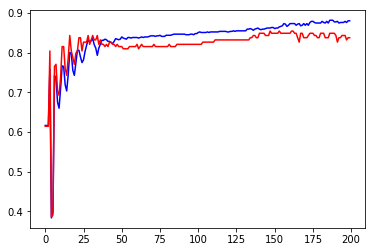

In [29]:
# session 초기화
sess = tf.Session()
# variable 초기화
sess.run(tf.global_variables_initializer())
# traing 시킬 데이터 수
num_examples = len(X_train)
print("Training ..")
print()

for i in range(EPOCHS):
    # train 데이터를 shuffling 후 사용 (여기서는 사용 안함)
    x_train_sh, y_train_sh = X_train, y_train
    
    # batch size 만큼씩 읽어서 training
    for offset in range(0, num_examples, BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x, batch_y = x_train_sh[offset:end], y_train_sh[offset:end]
        
        # feed training data and run
        sess.run(training_op,feed_dict={x_placeholder:batch_x, y_placeholder:batch_y,prob:1.0})
    
    # 검증용 test data accuracy 측정 (EPOCH 단위로)
    valid_acc = evaluate(X_test, y_test,sess)
    # train data accuracy 측정 (EPOCH 단위로)
    train_acc = evaluate(x_train_sh, y_train_sh,sess)
    # for graph
    list_train_accuracy.append(train_acc)
    list_valid_accuracy.append(valid_acc)
    
    print('\r',"EPOCH {} ...".format(i+1),
          "Validation Accuracy = {:.3f} ...".format(valid_acc),
          "Training Accuracy = {:.3f} ...".format(train_acc),end='')
    if len(epochs) == 0:
        epochs.append(0)
    else:
        epochs.append(epochs[-1]+1)

# plotting Accuracy graph
plt.plot(epochs,list_train_accuracy,'b-',epochs,list_valid_accuracy,'r-')
plt.show()

## Predict (kaggle submit)

In [30]:
# prediction 값
pred = tf.argmax(hypothesis, 1)

# kaggle 제출용 test data
X_test_arr = X_test_submit.values

# 이미 학습된 상태의 hypothesis 노드에 predict 할 신규 test 데이터를 feed 함
predicted_labels = sess.run(pred, feed_dict={x_placeholder: X_test_arr,prob: 1.0})

### Make submit file

In [31]:
# 제출용 데이터 생성
d = {'PassengerId': test.index, 'Survived': predicted_labels}
prediction_df = pd.DataFrame(data=d)
print(prediction_df.shape)
prediction_df.head()

(418, 2)


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [32]:
# 저장할 파일을 구분하기 위해 파일명에 timestamp 정보 추가 하기 위한 작업 
from datetime import datetime

current_date = datetime.now()
current_date = current_date.strftime("%Y-%m-%d_%H-%M-%S")

description = "titanic-multilayer-nn"

filename = "{date}_{desc}.csv".format(date=current_date, desc=description)
filepath = "data/{filename}".format(filename=filename)

prediction_df.to_csv(filepath, index=False)